In [21]:
!pip install yfinance
!pip install numpy==1.23.5
!pip install river

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
## We need to make sure that the version of python is the 1.23.5 to avoid problems while importing packages from River
import numpy as np
np.__version__ 

'1.23.5'

In [23]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
 
# Here We are getting Facebook financial information
# We need to pass FB as argument for that
ticker_list=["META","BNP.PA","BABA","GAZP.ME","2222.SR","FCAU.VI","^GSPC"]
dict_df={}
for i in ticker_list: 
  tick = yf.Ticker(i)
  #df=tick.history(period="max")
  df=tick.history(start="2015-01-05")
  df1 = df.drop(["Dividends","Stock Splits"],axis=1)
  df1["Mid"] = (df1["High"] + df1["Low"])/2
  df1["return"]=df1["Close"].pct_change()
 
  dict_df[i]=df1

In [24]:
dict_df["META"]

,Open,High,Low,Close,Volume,Mid,return
Date,,,,,,,
2015-01-05 00:00:00-05:00,77.980003,79.250000,76.860001,77.190002,26452200,78.055000,NaN
2015-01-06 00:00:00-05:00,77.230003,77.589996,75.360001,76.150002,27399300,76.474998,-0.013473
2015-01-07 00:00:00-05:00,76.760002,77.360001,75.820000,76.150002,22045300,76.590000,0.000000
2015-01-08 00:00:00-05:00,76.739998,78.230003,76.080002,78.180000,23961000,77.155003,0.026658
2015-01-09 00:00:00-05:00,78.199997,78.620003,77.199997,77.739998,21157000,77.910000,-0.005628
...,...,...,...,...,...,...,...
2023-01-09 00:00:00-05:00,131.160004,132.949997,129.279999,129.470001,26649100,131.114998,-0.004230
2023-01-10 00:00:00-05:00,127.269997,133.440002,127.150002,132.990005,28684400,130.295002,0.027188
2023-01-11 00:00:00-05:00,130.960007,133.850006,130.339996,132.889999,25423000,132.095001,-0.000752


## Making predictions in a datastream

In [25]:
from river import metrics
from river import utils
from river.stream import iter_pandas
from river import linear_model 
from river import preprocessing
from river import linear_model
from river import compose
from river import optim 
from river.tree import HoeffdingTreeClassifier
from river.neighbors import KNNClassifier
from river.ensemble import AdaBoostClassifier, AdaptiveRandomForestClassifier
from river import feature_extraction
from river import stats
from river import evaluate

In [26]:
def print_progress_binary(sample_id, acc, kappa, F1):
  print(f'Samples processed: {sample_id}')
  print(acc)
  print(kappa)
  print(F1)

scaler = preprocessing.StandardScaler()
def compute_volatility(list_prices):
  df_prices = pd.DataFrame(list_prices)
  if len(list_prices)<5:
    rep=0.0
  else:
    rep = np.std(np.array(df_prices.pct_change()[1:]))
  return rep

def evaluate_binary(stream, model, n_wait, low_bound, high_bound, verbose=False):
  acc = metrics.BalancedAccuracy()
  kappa = metrics.CohenKappa()
  F1 = metrics.WeightedF1()
  raw_results = []
  model_name = model.__class__.__name__
  tab_pred = []
  tab_y_true = []
  list_mm = []
  x_pred = {}
  for i, (x, y_1) in enumerate(stream):
    if len(list_mm)>n_wait:
      list_mm.pop(0)
    list_mm.append(x["Close"])
    x["MM_Close"] = np.mean(list_mm)
    #x["Volatility"] = compute_volatility(list_mm)
    if len(list_mm)==1:
      x_scaled = scaler.learn_one(x).transform_one(x)
    if len(list_mm)>1:  
      x_scaled = scaler.learn_one(x_pred).transform_one(x_pred)  
      if (x["Close"] - x_pred["Close"]) /  x_pred["Close"] <low_bound :
        y=0
      if (x["Close"] - x_pred["Close"]) /  x_pred["Close"] > low_bound and (x["Close"] - x_pred["Close"]) /  x_pred["Close"] < high_bound :
        y=1
      if (x["Close"] - x_pred["Close"]) /  x_pred["Close"] > high_bound :
        y=2
      tab_y_true.append(y)
      y_pred = model.predict_one(x_scaled)
      tab_pred.append(y_pred)
      acc.update(y_true=y, y_pred=y_pred)
      kappa.update(y_true=y, y_pred=y_pred)
      F1.update(y_true=y, y_pred=y_pred)
      if i%n_wait == 0 and i>0:
        if verbose:
          print_progress_binary(i, acc, kappa, F1)
        raw_results.append([model_name, i, acc.get(), kappa.get(), F1.get()])
      model.learn_one(x_scaled,y)
    x_pred = x
  print_progress_binary(i, acc, kappa, F1)
  return pd.DataFrame(raw_results, columns=["model", "id", "acc","kappa", "F1"]), tab_pred, tab_y_true


## Binary Prediction

First, we start by studying binary predictions. The objective is here to predict the direction of the future mouvement (and not its value). We know that we are loosing a lot of information by working with 0 and 1, but it is also for an educational purpose to let us implement classification algorithms. We can also say that some mutual funds are trying to predict the moove of the financial markets and not the value of the moove (see Capital Fund Management project on prediction of the american stock market between 2PM and 4PM)

In [ ]:
start_date = 0
for i in dict_df["META"].index:
  if str(i).split(" ")[0] == "2020-01-06":
    break
  start_date+=1

In [ ]:
df_binary = dict_df["META"][start_date:]

In [27]:
X = df_binary[["Open","High","Low","Close","Volume","Mid"]]
Y = pd.Series(np.zeros(len(X)), index=X.index)


knn = KNNClassifier(n_neighbors=10, window_size=60)
ht = HoeffdingTreeClassifier()
AdaBoost = AdaBoostClassifier(model=HoeffdingTreeClassifier(), n_models=5,seed=42)
RF_model = AdaptiveRandomForestClassifier(seed=8, leaf_prediction="mc")
low_bound = np.percentile(dict_df["META"]["return"][1:start_date], 35)
high_bound = np.percentile(dict_df["META"]["return"][1:start_date], 65)
n_wait = 60

In [ ]:
knn_results, tab_pred_knn, tab_y_true_knn = evaluate_binary(stream=iter_pandas(X=X, y=Y), model=knn,n_wait=n_wait, low_bound=low_bound, high_bound=high_bound)

Samples processed: 762
BalancedAccuracy: 25.28%
CohenKappa: 0.79%
WeightedF1: 37.27%


In [ ]:
ht_results, tab_pred_ht, tab_y_true_ht = evaluate_binary(stream=iter_pandas(X=X, y=Y),
                      model=ht, n_wait=n_wait, low_bound=low_bound, high_bound=high_bound)

Samples processed: 762
BalancedAccuracy: 24.83%
CohenKappa: -0.45%
WeightedF1: 36.37%


In [ ]:
Adaboost_results, tab_pred_Adaboost, tab_y_true_Adaboost = evaluate_binary(stream=iter_pandas(X=X, y=Y),
                      model=AdaBoost, n_wait=n_wait, low_bound=low_bound, high_bound=high_bound)

Samples processed: 762
BalancedAccuracy: 25.09%
CohenKappa: -0.94%
WeightedF1: 34.26%


In [ ]:
RF_results, tab_pred_RF, tab_y_true_RF = evaluate_binary(stream=iter_pandas(X=X, y=Y),
                      model=RF_model, n_wait=n_wait, low_bound=low_bound, high_bound=high_bound)

Samples processed: 762
BalancedAccuracy: 23.04%
CohenKappa: -5.04%
WeightedF1: 34.20%


In [ ]:
df_plot = pd.concat([knn_results, ht_results, Adaboost_results, RF_results])
df_plot.set_index('id', inplace=True)
grouped = df_plot.groupby('model')

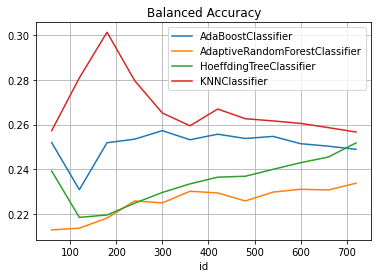

In [ ]:
grouped["acc"].plot(title="Balanced Accuracy", legend=True)
plt.grid()

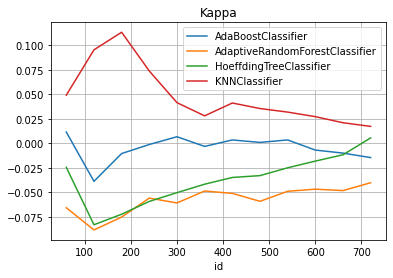

In [ ]:
grouped["kappa"].plot(title="Kappa", legend=True)
plt.grid()

## Returns prediction

We are now trying to predict the value of the future returns

In [ ]:
df_real = dict_df["META"][start_date:]
X_real = df_real[["Open","High","Low","Close","Volume","Mid"]]
X_real["return_benchmark"] = dict_df["^GSPC"][start_date:]["return"]
Y_real = pd.Series(np.zeros(len(X_real)), index=X_real.index)

Having a single value for the predicition can be restrictive in order to take a decision about the future returns. We can do a quantile regression to have a prediction interval instead of a single value.
This interval can also be interesting for risk management where ones want to know the potential value of a negative returns on the portfolio.

In [ ]:
def make_model(alpha):
    scale = preprocessing.StandardScaler()

    learn = linear_model.LinearRegression(
        intercept_lr=0,
        optimizer=optim.SGD(0.03),
        loss=optim.losses.Quantile(alpha=alpha)
    )

    model = scale | learn
    model = preprocessing.TargetStandardScaler(regressor=model)

    return model

def print_progress_real(sample_id, MAE):
  print(f'Samples processed: {sample_id}')
  print(MAE)

def evaluate_prediction_interval(stream, models, n_wait, verbose=False):
  MAE = metrics.MAE()
  y_preds = {'lower': [], 'center': [],'upper': []}
  raw_results = []
  tab_y_true = []
  list_mm = []
  x_pred = {}
  for i,(x,y_1) in enumerate(stream):
    if len(list_mm)>n_wait:
      list_mm.pop(0)
    list_mm.append(x["Close"])
    x["MM_Close"] = np.mean(list_mm)
    if len(list_mm)>1:  
      y = (x["Close"] - x_pred["Close"]) /  x_pred["Close"]
      tab_y_true.append(y)
      for name, model in models.items():
        y_pred = model.predict_one(x)
        y_preds[name].append(y_pred)
        model.learn_one(x,y)
      MAE.update(y_true=y, y_pred=y_preds["center"][-1])
      if i%n_wait == 0 and i>0:
        if verbose:
          print_progress_real(i, MAE)
        raw_results.append([models["center"].__class__.__name__, i, MAE.get()])
    x_pred = x
  print_progress_real(i, MAE)
  return pd.DataFrame(raw_results, columns=["model", "id", "MAE"]), y_preds, tab_y_true

In [ ]:
models = {
    'lower': make_model(alpha=0.05),
    'center': make_model(alpha=0.5),
    'upper': make_model(alpha=0.95)
}

Quantile_regression_results, y_pred_quantile, tab_y_true_reg = evaluate_prediction_interval(stream=iter_pandas(X=X_real, y=Y_real), models = models, n_wait=30)

/usr/local/lib/python3.8/dist-packages/river/preprocessing/scale.py:594: RuntimeWarning: invalid value encountered in double_scalars
  return (y - self.var.mean.get()) / self.var.get() ** 0.5


Samples processed: 762
MAE: 0.016261


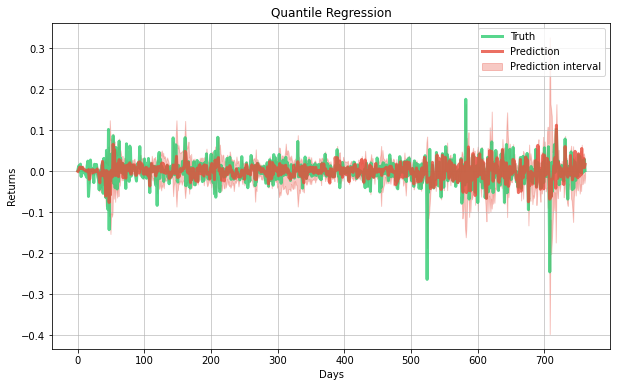

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(np.arange(len(y_pred_quantile["center"])), tab_y_true_reg, lw=3, color='#2ecc71', alpha=0.8, label='Truth')
ax.plot(np.arange(len(y_pred_quantile["center"])), y_pred_quantile['center'], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.fill_between(np.arange(len(y_pred_quantile["center"])), y_pred_quantile['lower'], y_pred_quantile['upper'], color='#e74c3c', alpha=0.3, label='Prediction interval')
plt.xlabel("Days")
plt.ylabel("Returns")
plt.title("Quantile Regression")
ax.legend()

It is also possible to combine both approaches. We can still have a classification problem but we can give some percentiles of the prediction interval in the features to give more insight of the current state of the financial market.

In [28]:
def make_model(alpha):
    scale = preprocessing.StandardScaler()

    learn = linear_model.LinearRegression(
        intercept_lr=0,
        optimizer=optim.SGD(0.03),
        loss=optim.losses.Quantile(alpha=alpha)
    )

    model = scale | learn
    model = preprocessing.TargetStandardScaler(regressor=model)

    return model

models = {
    '0.1': make_model(alpha=0.1),
    '0.3': make_model(alpha=0.3),
    'center': make_model(alpha=0.5),
    '0.6': make_model(alpha=0.6),
    '0.8': make_model(alpha=0.8),
    '0.95': make_model(alpha=0.95)
}

In [29]:
def evaluate_binary_with_prediction_interval(stream, model_binary, models, n_wait, low_bound, high_bound, verbose=False):
  acc = metrics.BalancedAccuracy()
  kappa = metrics.CohenKappa()  
  F1 = metrics.WeightedF1()
  raw_results = []
  model_name = model_binary.__class__.__name__
  tab_pred = []
  tab_y_true = []
  list_mm = []
  x_pred = {}
  for i, (x, y_1) in enumerate(stream):
    if len(list_mm)>n_wait:
      list_mm.pop(0)
    list_mm.append(x["Close"])
    x["MM_Close"] = np.mean(list_mm)
    #x["Volatility"] = compute_volatility(list_mm)
    if len(list_mm)==1:
      x_scaled = scaler.learn_one(x).transform_one(x)
    if len(list_mm)>1:  
      y_true_reg = (x["Close"] - x_pred["Close"]) /  x_pred["Close"]
      for name, model in models.items():
        y_pred_reg = model.predict_one(x)
        x_pred[name] = y_pred_reg
        model.learn_one(x,y_true_reg)
      x_scaled = scaler.learn_one(x_pred).transform_one(x_pred)  
      if (x["Close"] - x_pred["Close"]) /  x_pred["Close"] <low_bound :
        y=0
      if (x["Close"] - x_pred["Close"]) /  x_pred["Close"] > low_bound and (x["Close"] - x_pred["Close"]) /  x_pred["Close"] < high_bound :
        y=1
      if (x["Close"] - x_pred["Close"]) /  x_pred["Close"] > high_bound :
        y=2
      tab_y_true.append(y)
      y_pred = model_binary.predict_one(x_scaled)
      tab_pred.append(y_pred)
      acc.update(y_true=y, y_pred=y_pred)
      kappa.update(y_true=y, y_pred=y_pred)
      F1.update(y_true=y, y_pred=y_pred)
      if i%n_wait == 0 and i>0:
        if verbose:
          print_progress_binary(i, acc, kappa, F1)
        raw_results.append([model_name, i, acc.get(), kappa.get(), F1.get()])
      model_binary.learn_one(x_scaled,y)
    x_pred = x
  print_progress_binary(i, acc, kappa, F1)
  return pd.DataFrame(raw_results, columns=["model_binary", "id", "acc","kappa", "F1"]), tab_pred, tab_y_true

In [46]:
X = df_binary[["Open","High","Low","Close","Volume","Mid"]]
Y = pd.Series(np.zeros(len(X)), index=X.index)


knn = KNNClassifier(n_neighbors=10, window_size=60)
ht = HoeffdingTreeClassifier()
AdaBoost = AdaBoostClassifier(model=HoeffdingTreeClassifier(), n_models=5,seed=42)
RF_model = AdaptiveRandomForestClassifier(seed=8, leaf_prediction="mc")
low_bound = np.percentile(dict_df["META"]["return"][1:start_date], 35)
high_bound = np.percentile(dict_df["META"]["return"][1:start_date], 65)

In [ ]:
## Classification without the adding of the features
knn_results, tab_pred_knn, tab_y_true_knn = evaluate_binary(stream=iter_pandas(X=X, y=Y), model=knn,n_wait=n_wait, low_bound=low_bound, high_bound=high_bound)

Samples processed: 762
BalancedAccuracy: 26.26%
CohenKappa: 2.26%
WeightedF1: 38.05%


In [ ]:
## Classification with the features coming from the regression
knn_results_int, tab_pred_knn_int, tab_y_true_knn_int = evaluate_binary_with_prediction_interval(stream=iter_pandas(X=X, y=Y), model_binary=knn, models = models, n_wait=n_wait, low_bound=low_bound, high_bound=high_bound)

/usr/local/lib/python3.8/dist-packages/river/preprocessing/scale.py:594: RuntimeWarning: invalid value encountered in double_scalars
  return (y - self.var.mean.get()) / self.var.get() ** 0.5


Samples processed: 762
BalancedAccuracy: 36.29%
CohenKappa: 3.83%
WeightedF1: 39.73%


We can see that the Balanced Accuracy is better by 10% with the addition of new features coming from the linear regression.

In [ ]:
ht_results_int, tab_pred_ht_int, tab_y_true_ht_int = evaluate_binary_with_prediction_interval(stream=iter_pandas(X=X, y=Y),
                      model_binary=ht,  models = models, n_wait=n_wait, low_bound=low_bound, high_bound=high_bound)

Samples processed: 762
BalancedAccuracy: 26.20%
CohenKappa: 1.96%
WeightedF1: 38.56%


In [ ]:
Adaboost_results_int, tab_pred_Adaboost_int, tab_y_true_Adaboost_int = evaluate_binary_with_prediction_interval(stream=iter_pandas(X=X, y=Y),
                      model_binary=AdaBoost, models = models, n_wait=n_wait, low_bound=low_bound, high_bound=high_bound)

Samples processed: 762
BalancedAccuracy: 28.40%
CohenKappa: 5.03%
WeightedF1: 37.86%


In [ ]:
RF_results_int, tab_pred_RF_int, tab_y_true_RF_int = evaluate_binary_with_prediction_interval(stream=iter_pandas(X=X, y=Y),
                      model_binary=RF_model, models = models, n_wait=n_wait, low_bound=low_bound, high_bound=high_bound)

Samples processed: 762
BalancedAccuracy: 25.95%
CohenKappa: 2.68%
WeightedF1: 38.46%


In [ ]:
df_plot_int = pd.concat([knn_results_int, ht_results_int, Adaboost_results_int, RF_results_int])
df_plot_int.set_index('id', inplace=True)
grouped_int = df_plot_int.groupby('model_binary')

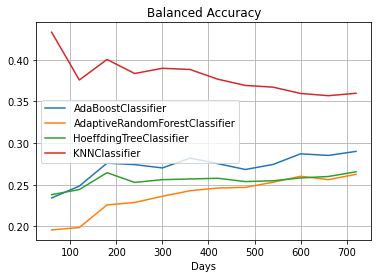

In [ ]:
grouped_int["acc"].plot(title="Balanced Accuracy", legend=True)
plt.legend(loc='best')
plt.xlabel("Days")
plt.grid()

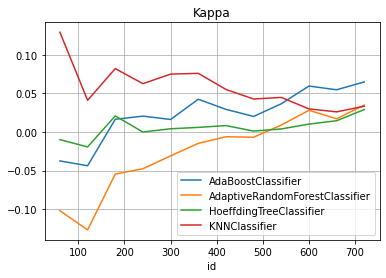

In [ ]:
grouped_int["kappa"].plot(title="Kappa", legend=True)
plt.grid()

In [ ]:
ticker_list=["META","BNP.PA","BABA","GAZP.ME","2222.SR","FCAU.VI","^GSPC"]

In [ ]:
dico_result = {}
for i in ticker_list[:-1]:
  start_date = 0
  for j in dict_df[i].index:
    if str(j).split(" ")[0] == "2020-01-06":
      break
    start_date+=1
  df_binary = dict_df[i][start_date:]
  X = df_binary[["Open","High","Low","Close","Volume","Mid"]]
  Y = pd.Series(np.zeros(len(X)), index=X.index)
  low_bound = np.percentile(df_binary["return"], 35)
  high_bound = np.percentile(df_binary["return"], 65)
  knn_results, tab_pred_knn, tab_y_true_knn = evaluate_binary(stream=iter_pandas(X=X, y=Y), model=knn,n_wait=n_wait, low_bound=low_bound, high_bound=high_bound)
  dico_result[i] = np.asarray(knn_results['acc'])

Samples processed: 762
BalancedAccuracy: 26.80%
CohenKappa: 3.53%
WeightedF1: 35.56%
Samples processed: 779
BalancedAccuracy: 33.67%
CohenKappa: 0.28%
WeightedF1: 33.08%
Samples processed: 762
BalancedAccuracy: 31.62%
CohenKappa: -2.58%
WeightedF1: 31.79%
Samples processed: 582
BalancedAccuracy: 34.35%
CohenKappa: 1.40%
WeightedF1: 34.31%
Samples processed: 756
BalancedAccuracy: 33.33%
CohenKappa: 0.00%
WeightedF1: 18.20%
Samples processed: 769
BalancedAccuracy: 33.33%
CohenKappa: 0.00%
WeightedF1: 18.13%


Text(0.5, 1.0, 'Balanced Accuracy for several stocks')

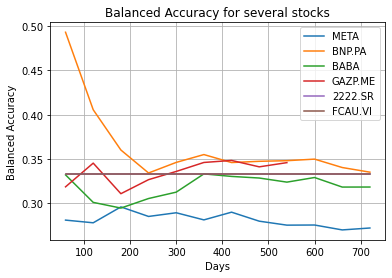

In [ ]:
for i in ticker_list[:-1]:
  plt.plot(np.arange(1,len(dico_result[i])+1)*n_wait, dico_result[i], label=i)
plt.grid()
plt.legend(loc='best') 
plt.xlabel("Days")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy for several stocks") 

## Implementation of the indicator $\widehat{I^{L+1}}$ from "A statistical test of market efficiency based on information theory", X.Brouty, M.Garcin [1]

[1] https://arxiv.org/abs/2208.11976v1

In [ ]:
import math
from collections import OrderedDict
from decimal import Decimal

In [ ]:
def binary_code_char(df):
    binary_code=''
    for k in df:
        if k>0:
            binary_code+='1'
        else:
            binary_code+='0'
    return binary_code

def calcul_proba(df):
    p_1=df.count('0')/len(df)
    p_2=df.count('1')/len(df)
    eps_1=0
    compt1=0
    compt2=0
    eps_2=0
    for i in range(0,len(df)-1):
        if df[i]=='0':
            if df[i+1]=='1':
                eps_1+=1
            compt1+=1
        if df[i]=='1':
            if df[i+1]=='1':
                eps_2+=1
            compt2+=1
    if compt1!=0:
        eps_1=eps_1/compt1 
    if compt2!=0:
        eps_2=eps_2/compt2
    return p_1,p_2,eps_1,eps_2

def i_efficient_ts(df):
    p_1,p_2,eps_1,eps_2=calcul_proba(df)
    #print(calcul_proba(df))
    if eps_1==0.0 and eps_2!=0 and p_1!=0:
        return p_1+p_2*eps_2*math.log(p_2*eps_2,2)+p_2*(1-eps_2)*math.log(p_2*(1-eps_2),2)-p_2*math.log(p_2/2,2)
    if eps_2==0.0 and eps_1!=0 and p_1!=0 and eps_1!=1:
        return p_1*eps_1*math.log(p_1*eps_1,2)+p_1*(1-eps_1)*math.log(p_1*(1-eps_1),2)-p_1*math.log(p_1/2,2)+p_2
    if eps_1==1.0 and eps_2!=1 and p_2!=0 and eps_2!=0:
        return  p_1+p_2*eps_2*math.log(p_2*eps_2,2)+p_2*(1-eps_2)*math.log(p_2*(1-eps_2),2)-p_2*math.log(p_2/2,2)
    if eps_2==1.0 and eps_1!=1 and p_1!=0:
        return p_1*eps_1*math.log(p_1*eps_1,2)+p_1*(1-eps_1)*math.log(p_1*(1-eps_1),2)-p_1*math.log(p_1/2,2)+p_2
    if eps_1==0.0 and eps_2==0.0:
        return 1
    if eps_1==0.0 and eps_2==1.0:
        return 1
    if eps_1==1.0 and eps_2==0.0:
        return 1
    if eps_1==1.0 and eps_2==1.0:
        return 1
    if p_1==0:
        if eps_2==0:
            return p_2
        if eps_2==1:
            return p_2
        else:
            return p_2*eps_2*math.log(p_2*eps_2,2)+p_2*(1-eps_2)*math.log(p_2*(1-eps_2),2)-p_2*math.log(p_2/2,2)
    if p_2==0:
        if eps_1==0:
            return p_1
        if eps_1==1:
            return p_1
        else:
            return p_1*eps_1*math.log(p_1*eps_1,2)+p_1*(1-eps_1)*math.log(p_1*(1-eps_1),2)-p_1*math.log(p_1/2,2)
    else: 
        return p_1*eps_1*math.log(p_1*eps_1,2)+p_1*(1-eps_1)*math.log(p_1*(1-eps_1),2)-p_1*math.log(p_1/2,2)+p_2*eps_2*math.log(p_2*eps_2,2)+p_2*(1-eps_2)*math.log(p_2*(1-eps_2),2)-p_2*math.log(p_2/2,2)


For the bootstrap

In [ ]:
def generate_efficient(nb):
    tab=str(np.random.randint(2))
    while len(tab)<nb:
        if tab[-1]=='0':
            proba=np.random.uniform(0,1)
            if proba>0.5:
                tab+='1'
            else:
                tab+='0'
        if tab[-1]=='1':
            proba=np.random.uniform(0,1)
            if proba>0.5:
                tab+='1'
            else:
                tab+='0'
    return tab

def bootstrap(nb1,nb2):
    tab=[]
    for i in range(0,nb1):
        tab_eff=generate_efficient(nb2)
        proba=calcul_proba(tab_eff)
        tab.append(i_efficient(proba[0],proba[1],proba[2],proba[3]))
    return tab

def i_efficient(p_1,p_2,eps_1,eps_2):
    if eps_1==0.0 and eps_2!=0 and p_1!=0:
        return p_1+p_2*eps_2*math.log(p_2*eps_2,2)+p_2*(1-eps_2)*math.log(p_2*(1-eps_2),2)-p_2*math.log(p_2/2,2)
    if eps_2==0.0 and eps_1!=0 and p_1!=0 and eps_1!=1:
        return p_1*eps_1*math.log(p_1*eps_1,2)+p_1*(1-eps_1)*math.log(p_1*(1-eps_1),2)-p_1*math.log(p_1/2,2)+p_2
    if eps_1==1.0 and eps_2!=1 and p_2!=0 and eps_2!=0:
        return  p_1+p_2*eps_2*math.log(p_2*eps_2,2)+p_2*(1-eps_2)*math.log(p_2*(1-eps_2),2)-p_2*math.log(p_2/2,2)
    if eps_2==1.0 and eps_1!=1 and p_1!=0:
        return p_1*eps_1*math.log(p_1*eps_1,2)+p_1*(1-eps_1)*math.log(p_1*(1-eps_1),2)-p_1*math.log(p_1/2,2)+p_2
    if eps_1==0.0 and eps_2==0.0:
        return 1
    if eps_1==0.0 and eps_2==1.0:
        return 1
    if eps_1==1.0 and eps_2==0.0:
        return 1
    if eps_1==1.0 and eps_2==1.0:
        return 1
    if p_1==0:
        if eps_2==0:
            return p_2
        if eps_2==1:
            return p_2
        else:
            return p_2*eps_2*math.log(p_2*eps_2,2)+p_2*(1-eps_2)*math.log(p_2*(1-eps_2),2)-p_2*math.log(p_2/2,2)
    if p_2==0:
        if eps_1==0:
            return p_1
        if eps_1==1:
            return p_1
        else:
            return p_1*eps_1*math.log(p_1*eps_1,2)+p_1*(1-eps_1)*math.log(p_1*(1-eps_1),2)-p_1*math.log(p_1/2,2)
    else: 
        return p_1*eps_1*math.log(p_1*eps_1,2)+p_1*(1-eps_1)*math.log(p_1*(1-eps_1),2)-p_1*math.log(p_1/2,2)+p_2*eps_2*math.log(p_2*eps_2,2)+p_2*(1-eps_2)*math.log(p_2*(1-eps_2),2)-p_2*math.log(p_2/2,2)


In [ ]:
tab_bootstrap = bootstrap(1000,n_wait)

In [ ]:
def evaluate_information(stream, n_wait):
  list_mm = np.random.choice(['0','1'])
  x_pred = {}
  tab_info = []
  for i, (x, y_1) in enumerate(stream):
    if len(list_mm) > 1:
      if x["Close"] > x_pred["Close"]:
        ret = '1'
      else:
        ret = '0'
      if len(list_mm)<n_wait:
        list_mm += ret        
      if len(list_mm)>=n_wait:
        list_mm = list_mm[1:]
        list_mm += ret
        proba=calcul_proba(list_mm)
        tab_info.append(i_efficient(proba[0],proba[1],proba[2],proba[3]))
    if len(list_mm)<=1:
      list_mm+=np.random.choice(['0','1'])
    x_pred = x
  return tab_info

In [ ]:
start_date = 0
for i in dict_df["FCAU.VI"].index:
  if str(i).split(" ")[0] == "2020-01-06":
    break
  start_date+=1

In [ ]:
df_binary = dict_df["FCAU.VI"][start_date:]

In [ ]:
X = df_binary[["Open","High","Low","Close","Volume","Mid"]]
Y = pd.Series(np.zeros(len(X)), index=X.index)

In [ ]:
tab_info = evaluate_information(stream=iter_pandas(X=X, y=Y), n_wait=n_wait)

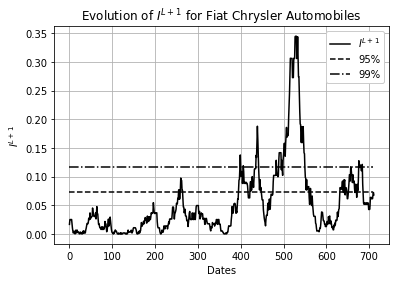

In [ ]:
plt.plot(tab_info,label="$I^{L+1}$",color="black")
plt.plot(np.arange(0,len(X["Close"])-n_wait,1),(len(X["Close"])-n_wait)*np.percentile(tab_bootstrap,[95]).tolist(),'--',label="95%",color="black")
plt.plot(np.arange(0,len(X["Close"])-n_wait,1),(len(X["Close"])-n_wait)*np.percentile(tab_bootstrap,[99]).tolist(),'-.',label="99%",color="black")
plt.legend(framealpha=1, frameon=True, loc='best')
plt.title("Evolution of $I^{L+1}$ for Fiat Chrysler Automobiles")
plt.xlabel("Dates")
plt.ylabel("$I^{L+1}$")
plt.grid()
plt.show()

## Construction of a portfolio with the stocks selected

For the moment, we did the classification and the regression for the stock META, but it is important to construct a portfolio with several stocks in order to improve the performance of the strategy by reducing the risks for a single stock. We are then doing a prediction at each end of the day for the $n$ stocks of the universe of investment and we buy the stocks with a prediction for the class 2. We will then run a backtest to see if this really simple strategy is working. 

We are going to start to simulate the predictions for all of the stocks. Because it is a backtest, we can compute all the predictions from start date to end date and simulate a portfolio with the predictions. It is not necessary to do this in streaming. 

In [31]:
ticker_list=["META", "AAPL", "AMZN", "TSLA", "MSFT", "GOOG", "PFE", "CVX", "^GSPC"]
dict_df_USA={}
for i in ticker_list: 
  tick = yf.Ticker(i)
  #df=tick.history(period="max")
  df=tick.history(start="2015-01-05")
  df1 = df.drop(["Dividends","Stock Splits"],axis=1)
  df1["Mid"] = (df1["High"] + df1["Low"])/2
  df1["return"]=df1["Close"].pct_change()
  list_return = list(df1["return"])[1:]
  list_return.append(0)
  df1["pred_backtest"] = list_return
 
  dict_df_USA[i]=df1

In [32]:
dic_stocks = {}
for i in list(dict_df_USA.keys()): ## The last ticker is the one of S&P 500 to have a feature representing the benchmark
  start_date = 0
  for date in dict_df_USA[i].index:
    if str(date).split(" ")[0] == "2020-01-06":
      break
    start_date+=1
  df_binary = dict_df_USA[i][start_date:]
  dic_stocks[i] = df_binary

Here we are working with stocks coming from the S&P 500 only, it allows to have the same trading day between all the stocks.

In [35]:
for i in dic_stocks.keys():
  print(i,len(dic_stocks[i]))

META 763
AAPL 763
AMZN 763
TSLA 763
MSFT 763
GOOG 763
PFE 763
CVX 763
^GSPC 763


In [36]:
dic_pred = {}
for i in list(dic_stocks.keys())[:-1]:
  X = dic_stocks[i][["Open", "High", "Low", "Close", "Volume", "Mid"]]
  Y = pd.Series(np.zeros(len(X)), index=X.index)
  low_bound = np.percentile(dic_stocks[i]["return"], 35)
  high_bound = np.percentile(dic_stocks[i]["return"], 65)
  knn_results_int, tab_pred_knn_int, tab_y_true_knn_int = evaluate_binary_with_prediction_interval(stream=iter_pandas(X=X, y=Y),
                                                                                                   model_binary=knn, models = models, n_wait=n_wait,
                                                                                                   low_bound=low_bound, high_bound=high_bound)
  dic_pred[i] = tab_pred_knn_int
  
  

/usr/local/lib/python3.8/dist-packages/river/preprocessing/scale.py:594: RuntimeWarning: invalid value encountered in double_scalars
  return (y - self.var.mean.get()) / self.var.get() ** 0.5


Samples processed: 762
BalancedAccuracy: 29.24%
CohenKappa: 8.41%
WeightedF1: 39.02%
Samples processed: 762
BalancedAccuracy: 40.36%
CohenKappa: 10.47%
WeightedF1: 40.44%
Samples processed: 762
BalancedAccuracy: 42.78%
CohenKappa: 13.98%
WeightedF1: 42.66%
Samples processed: 762
BalancedAccuracy: 39.89%
CohenKappa: 9.82%
WeightedF1: 40.08%
Samples processed: 762
BalancedAccuracy: 40.78%
CohenKappa: 11.27%
WeightedF1: 41.02%
Samples processed: 762
BalancedAccuracy: 33.05%
CohenKappa: -0.91%
WeightedF1: 32.94%
Samples processed: 762
BalancedAccuracy: 35.70%
CohenKappa: 3.57%
WeightedF1: 35.89%
Samples processed: 762
BalancedAccuracy: 31.74%
CohenKappa: -2.46%
WeightedF1: 31.87%


In [37]:
def portfolio_construction(dic_stocks):
  dic_pred = {}
  for i in list(dic_stocks.keys())[:-1]:
    X = dic_stocks[i][["Open", "High", "Low", "Close", "Volume", "Mid"]]
    Y = pd.Series(np.zeros(len(X)), index=X.index)
    low_bound = np.percentile(dic_stocks[i]["return"], 35)
    high_bound = np.percentile(dic_stocks[i]["return"], 65)
    knn_results_port, tab_pred_knn_port, tab_y_true_knn_port = evaluate_binary_with_prediction_interval(stream=iter_pandas(X=X, y=Y),
                                                                                                    model_binary=knn, models = models, n_wait=n_wait,
                                                                                                    low_bound=low_bound, high_bound=high_bound)
    dic_pred[i] = tab_pred_knn_port
  list_return = []
  for day in range(len(dic_pred[list(dic_pred.keys())[0]])):
    list_buy = []
    for stocks in dic_pred.keys():
      if dic_pred[stocks][day] == 2:
        list_buy.append(stocks)
    n = len(list_buy)
    return_day = 0
    if n!=0:
      for day_stocks in list_buy:
        return_day += dic_stocks[day_stocks]["pred_backtest"][1+day]
      return_day = return_day / n
    if n==0:
      return_day = 0
    list_return.append(return_day)
  
  return list_return

In [47]:
list_return_portfolio = portfolio_construction(dic_stocks)

Samples processed: 762
BalancedAccuracy: 38.43%
CohenKappa: 27.45%
WeightedF1: 51.75%
Samples processed: 762
BalancedAccuracy: 52.79%
CohenKappa: 29.68%
WeightedF1: 53.18%
Samples processed: 762
BalancedAccuracy: 61.35%
CohenKappa: 42.66%
WeightedF1: 61.76%
Samples processed: 762
BalancedAccuracy: 52.85%
CohenKappa: 29.73%
WeightedF1: 53.15%
Samples processed: 762
BalancedAccuracy: 51.64%
CohenKappa: 28.67%
WeightedF1: 52.10%
Samples processed: 762
BalancedAccuracy: 48.18%
CohenKappa: 22.74%
WeightedF1: 48.36%
Samples processed: 762
BalancedAccuracy: 33.83%
CohenKappa: 0.48%
WeightedF1: 33.94%
Samples processed: 762
BalancedAccuracy: 43.58%
CohenKappa: 16.09%
WeightedF1: 43.80%


In [39]:
list_return_cumul = (1 + np.array(list_return_portfolio)).cumprod()

In [40]:
list_return_cumul_SP500 = (1 + np.array(dic_stocks["^GSPC"]["pred_backtest"])).cumprod()

In [41]:
list_returns_equal_weighted = []
for day in range(len(dic_pred[list(dic_pred.keys())[0]])):
  list_daily = []
  for i in list(dic_stocks.keys())[:-1]:
    list_daily.append(dic_stocks[i]["return"][day])
  list_returns_equal_weighted.append(np.mean(list_daily))


In [42]:
list_cumul_equal_weighted = (1 + np.array(list_returns_equal_weighted)).cumprod()

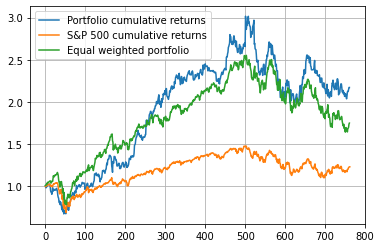

In [48]:
plt.plot(list_return_cumul, label='Portfolio cumulative returns')
plt.plot(list_return_cumul_SP500, label='S&P 500 cumulative returns')
plt.plot(list_cumul_equal_weighted, label='Equal weighted portfolio')
plt.legend()
plt.grid()

This comment was written for another returns for our portoflio (the one in the slides) : We can see that our portfolio has a better performance than the S&P 500 (at the end it becomes quite similar). But we can compare our strategy to an Equal weighted portfolio where each stocks of the universe of investment are equally weighted. 
The results are quite the ones expected, our portfolio is better than the S&P 500 because we take the best performing stocks of the S&P 500 of this period so there is a bias if we do compare like this.
A better comparison is the one against the equal weighted portfolio. And we see that it is better to invest with equal weights each day with all the stocks of the universe instead of doing a prediction and invest on the stocks with the better returns prediction for the following day. 

With the figure above we can see that our strategy is surperforming the equal weighted portfolio also. We can think that this performance comes also from the fact that we did not take into account the fees for the transactions. In reality, we can think that our strategy will have poorer results than the equal weighted strategy. 